<a href="https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/main/ThermoclineEndMemberDefinition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
!pip install gsw
!pip install csaps

In [4]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr" -O GLODAPv2.2019_Pacific_Ocean.csv && rm -rf /tmp/cookies.txt

--2021-09-13 01:59:12--  https://docs.google.com/uc?export=download&confirm=oSvy&id=1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr
Resolving docs.google.com (docs.google.com)... 142.250.141.113, 142.250.141.138, 142.250.141.100, ...
Connecting to docs.google.com (docs.google.com)|142.250.141.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-6c-docs.googleusercontent.com/docs/securesc/l4ugi2pbci5de6vod9ics97o06njk6l9/o13e0f2rkevd9eh2sqfjvp03dvrgllmo/1631498325000/06203730782251856755/17932746007061921320Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download [following]
--2021-09-13 01:59:12--  https://doc-0c-6c-docs.googleusercontent.com/docs/securesc/l4ugi2pbci5de6vod9ics97o06njk6l9/o13e0f2rkevd9eh2sqfjvp03dvrgllmo/1631498325000/06203730782251856755/17932746007061921320Z/1E9XGag2_uC2TM_5DcOcmSz86I1xj6hHr?e=download
Resolving doc-0c-6c-docs.googleusercontent.com (doc-0c-6c-docs.googleusercontent.com)... 74.125.137.132, 2607:f8b0:4023:c03::84
Connec

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas
import gsw

Read in the data frame and pick a subset of columns

In [6]:
colnames_subset = ["latitude", 'longitude', 'year', 'depth',
                   'pressure', 'temperature','salinity','oxygen',
                   'silicate', 'nitrate', 'phosphate', 'sigma0']


df = pandas.read_csv("GLODAPv2.2019_Pacific_Ocean.csv",
                     na_values = -9999)[colnames_subset]

df['NO'] = df['oxygen'] + (df['nitrate']*9.68)
df['PO'] = df['oxygen'] + (df['phosphate']*155)
df['potential_temp'] = gsw.pt_from_t(df['salinity'],
                                df['temperature'],
                                df['pressure'],
                                df['sigma0'])
df["absolute_salinity"] = gsw.SA_from_SP(
    SP=df["salinity"], p=df["pressure"],
    lon=df["longitude"], lat=df["latitude"])
df["conservative_temp"] = gsw.CT_from_t(SA=df["absolute_salinity"],
                                  t=df["temperature"],
                                  p=df["pressure"])
df["sigma2"] = gsw.sigma2(SA=df["absolute_salinity"],CT=df["conservative_temp"])
df["sigma4"] = gsw.sigma4(SA=df["absolute_salinity"],CT=df["conservative_temp"])

PSUW


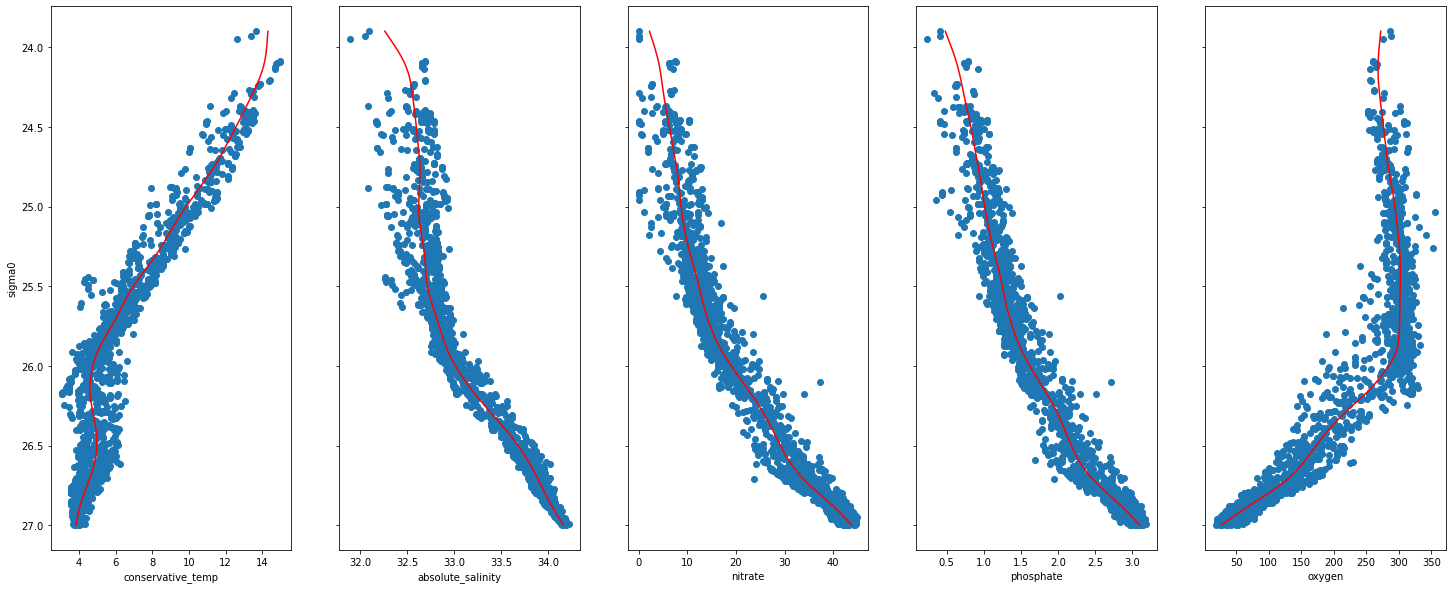

ENPCW


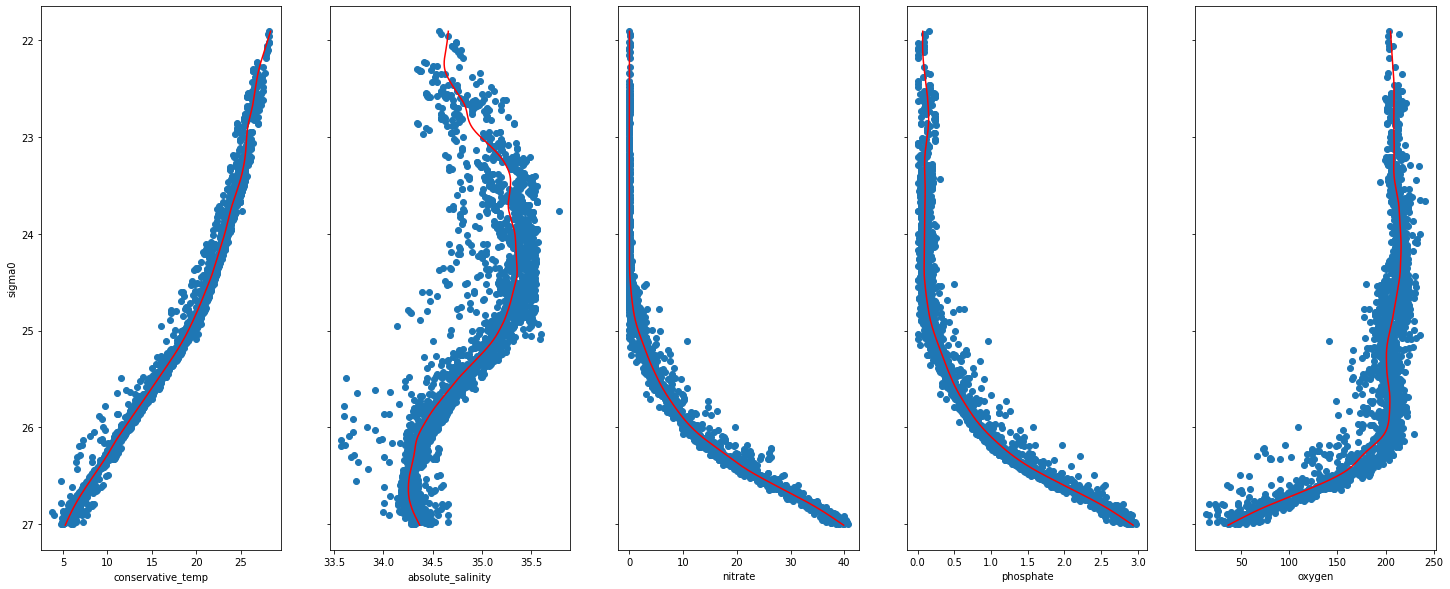

ESSW


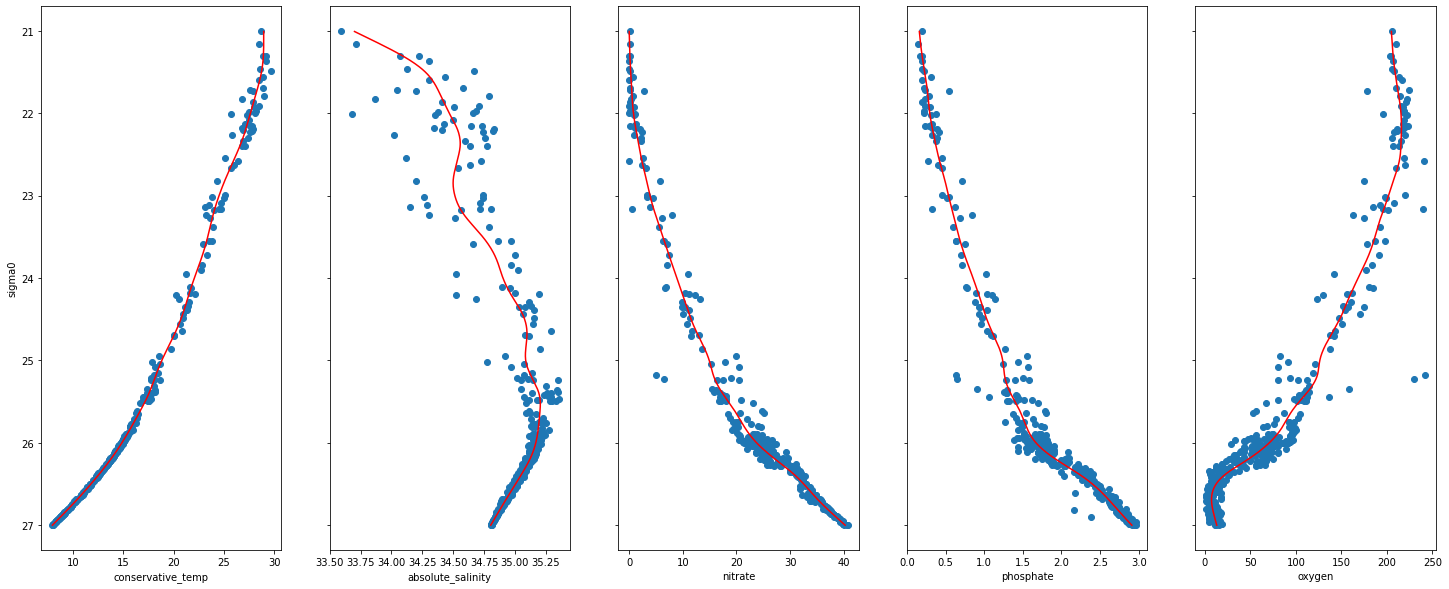

SPCW


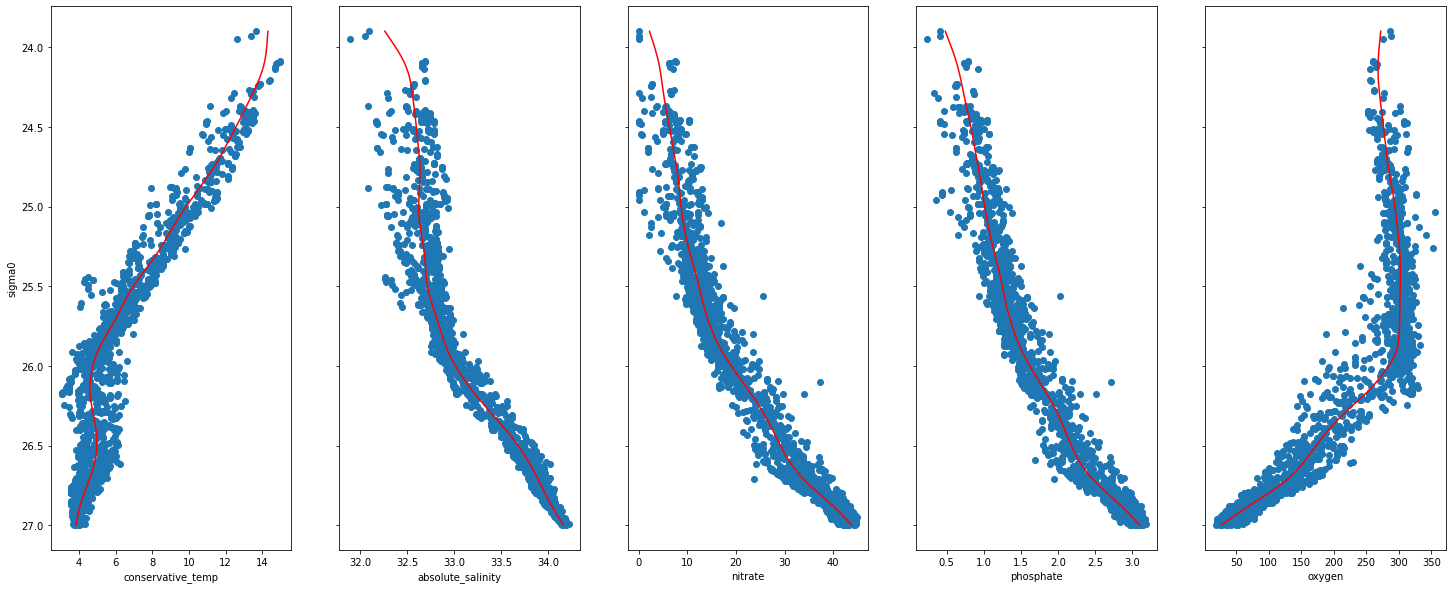

In [92]:
import scipy
import scipy.interpolate
import sklearn
import sklearn.model_selection
import numpy as np
from collections import OrderedDict, defaultdict
from matplotlib import pyplot as plt
from csaps import csaps

STEP_SIZE = 0.01
FEATURES_TO_INTERPOLATE = ["conservative_temp", "absolute_salinity",
                           "nitrate", "phosphate", "oxygen"]


class CsapsEstimator(object):

    def __init__(self, p):
        self.p = p

    def fit(self, data, targets):
        self.interpolator = csaps(xdata=data,ydata=targets,smooth=self.p)
        return self
    
    def fit_predict(self, data, targets):
        self.fit(data=data, targets=targets)
        return self.predict(data=data)
    
    def predict(self, data):
        return self.interpolator(data)
    
    def get_params(self, deep=True):
        return {'p':self.p}


def get_interpolation(x,y,intervals):
    return csaps(xdata=x, ydata=y, xidata=intervals, smooth=0.97)
    #argsort so the cv split will be spread
    argsortx = np.argsort(x)
    x = x[argsortx]
    y = y[argsortx]

    #remove outliers
    initial_fit_y = CsapsEstimator(p=0.97).fit_predict(data=x, targets=y)
    square_errors = np.square(y-initial_fit_y)
    stdev_square_error = np.std(square_errors)
    outlier_flags = square_errors > 3*stdev_square_error

    x_nooutliers = x[outlier_flags==False]
    y_nooutliers = y[outlier_flags==False]

    #Use a binary search & cross-validation technique to find a good value for s
    #Get CV splits for x

    #let's try to get an estimate for the variance of y[i]. Separate into bins
    # equal to 1/1000 of the range, then compute variance for each bin.
    minx = np.min(x)
    x_bin_size = (np.max(x) - minx)/100.0
    binstart_to_ys = defaultdict(list)
    for (this_x, this_y) in zip(x,y):
      binstart = minx + int((this_x - minx)/x_bin_size)
      binstart_to_ys[binstart].append(this_y)
    vary = np.sum([np.var(ys_in_bin)*len(ys_in_bin)
                    for ys_in_bin in binstart_to_ys.values()])/len(y)
    print("initial estimate of variance of y[i] is:",vary)

    def get_cv_score(p,x,y):
        return np.mean(sklearn.model_selection.cross_validate(
            estimator=CsapsEstimator(p=p),
            X=x, y=y, scoring="neg_mean_absolute_error",
            cv=sklearn.model_selection.RepeatedKFold(
                n_splits=5, n_repeats=5, random_state=1234
                ))['test_score'])

    p_to_try = 0.97
    #initialize
    best_neg_mse = get_cv_score(p_to_try,x_nooutliers, y_nooutliers)
    best_p = p_to_try
    print("With p=",p_to_try,"negmse is",best_neg_mse)
    plt.figure(figsize=(5,5))
    plt.scatter(y, -x, c=outlier_flags)
    plt.plot(CsapsEstimator(p=p_to_try).fit(
                data=x_nooutliers,
                targets=y_nooutliers).predict(intervals),
              -intervals, color="red")
    plt.show()

    upperbound_p = 1.0
    lowerbound_p = 0.0

    iternum=0
    while True:
        iternum += 1
        if (upperbound_p == np.inf):
            p_to_try = best_p*2
        elif (lowerbound_p == 0):
            p_to_try = best_p/2.0
        else:
            p_to_try = 0.5*(upperbound_p + lowerbound_p)

        neg_mse = get_cv_score(p_to_try,x_nooutliers,y_nooutliers)
        print("With p=",p_to_try,"negmse is",neg_mse)
        plt.figure(figsize=(5,5))
        plt.scatter(y, -x, c=outlier_flags)
        plt.plot(CsapsEstimator(p=p_to_try).fit(
                    data=x_nooutliers,
                    targets=y_nooutliers).predict(intervals),
                 -intervals, color="red")
        plt.show()
        
        #if the neg_mse is worse, use this to tighten the bounds for the binary
        # search
        if (neg_mse <= best_neg_mse):
            if (p_to_try > best_p):
                upperbound_p = p_to_try
            else:
                lowerbound_p = p_to_try
        else:
            if (p_to_try > best_p):
                lowerbound_p = best_p
            else:
                upperbound_p = best_p
            best_p = p_to_try
            best_neg_mse = neg_mse

        if (np.abs(upperbound_p - lowerbound_p) < 0.01):
            print("With best_p=",best_p,"negmse is",best_neg_mse)
            best_estimator = CsapsEstimator(p=best_p)
            best_estimator.fit(data=x_nooutliers, targets=y_nooutliers)
            break
        if iternum==100:
            assert False

    interpolated_features = best_estimator.predict(intervals)

    plt.figure(figsize=(5,5))
    plt.scatter(y, -x, c=outlier_flags)
    plt.plot(interpolated_features, -intervals, color="red")
    plt.show()

    return interpolated_features


def get_median_y_per_x(x,y):
  #deduplication
  x_to_ys = defaultdict(list)
  for an_x, a_y in zip(x, y):
    x_to_ys[an_x].append(a_y)

  ys = []
  xs = []
  for x in sorted(x_to_ys.keys()):
    xs.append(x)
    ys.append(np.median(x_to_ys[x]))
  
  return np.array(xs), np.array(ys)


def filter_df_for_range_and_interpolate(watertype_name, big_df,
                                        #k,
                                        depth_min=-np.inf, depth_max=np.inf,
                                        lat_min=-np.inf, lat_max=np.inf,
                                        lon_min=-np.inf, lon_max=np.inf,
                                        sig0_min=-np.inf, sig0_max=np.inf, ):
  filtered_df = df[(df['latitude'] >= lat_min) & (df['latitude'] <= lat_max)
     & (df['longitude'] >= lon_min) & (df['longitude'] <= lon_max)
     & (df['sigma0'] >= sig0_min) & (df['sigma0'] <= sig0_max)
     & (df['depth'] >= depth_min) & (df['depth'] <= depth_max) ]
  
  orig_x = np.array(filtered_df['sigma0'])
  
  x_min = int(np.ceil(min(orig_x)/STEP_SIZE))*STEP_SIZE
  x_max = int(max(orig_x)/STEP_SIZE)*STEP_SIZE
  intervals = np.array([x_min+(step*STEP_SIZE) for step in 
                       range(int((x_max-x_min)/STEP_SIZE) + 2)])
  
  interpolated_feature_dict = OrderedDict()
  interpolated_feature_dict["sigma0"] = intervals

  print(watertype_name)
  fig, ax = plt.subplots(nrows=1, ncols=len(FEATURES_TO_INTERPOLATE),
                         sharey=True,
                         figsize=(len(FEATURES_TO_INTERPOLATE)*5, 10))
  for idx,feature_name in enumerate(FEATURES_TO_INTERPOLATE):
    orig_y = np.array(filtered_df[feature_name])
    #filter out nans
    filt_x = orig_x[np.isfinite(orig_y)]
    filt_y = orig_y[np.isfinite(orig_y)]

    x,y = get_median_y_per_x(x=filt_x,y=filt_y)
    
    interpolated_features = get_interpolation(x=x,
        y=y,
        #k=k,
        intervals=intervals)
    
    interpolated_feature_dict[feature_name] = interpolated_features
    plt.sca(ax[idx])
    plt.xlabel(feature_name)
    #plt.scatter(orig_y, orig_x)
    plt.scatter(y, x)
    plt.plot(interpolated_features, intervals, color="red")

  plt.sca(ax[0])
  plt.ylabel("sigma0")
  plt.ylim(plt.ylim()[1], plt.ylim()[0])
  
  plt.show()

  pandas.DataFrame(interpolated_feature_dict).to_csv(watertype_name+".csv", index=False)

#big_df refers to the glodap df.
#s controls smoothing of the spline
#k controls the degree of the spline. k=4 is a quartic spline.
# Cubic spline seemed less reliable

filter_df_for_range_and_interpolate(watertype_name="PSUW",
                                    big_df=df, lat_min=50, lat_max=58,
                                    lon_min=-155, lon_max=-140,
                                    sig0_min=21, sig0_max=27,
                                    #s=1000000,
                                    #k=4
                                    )

filter_df_for_range_and_interpolate(watertype_name="ENPCW",
                                    big_df=df, lat_min=16, lat_max=26,
                                    lon_min=-170, lon_max=-140,
                                    sig0_min=21, sig0_max=27,
                                    #s=1000000*0.5,
                                    #k=4
                                    )

filter_df_for_range_and_interpolate(watertype_name="ESSW",
                                    big_df=df, lat_min=-5, lat_max=5,
                                    lon_min=-90, lon_max=-80,
                                    sig0_min=21, sig0_max=27,
                                    #s=1000000,
                                    #k=4
                                    )

filter_df_for_range_and_interpolate(watertype_name="SPCW",
                                    big_df=df, lat_min=50, lat_max=58,
                                    lon_min=-155, lon_max=-140,
                                    sig0_min=21, sig0_max=27,
                                    #s=1000000,
                                    #k=4
                                    )
